In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import timeit

# Application to Yeast Glycolysis

Glycolysis is the process of breaking down glucose to extract energy (ATP and NADPH). Understanding the metabolic networks of glycolysis is of interest for metabolic engineering (e.g. biofuel/drug production).

![cartoon](https://ars.els-cdn.com/content/image/1-s2.0-S0301462203001911-gr1.jpg)

The model is due to
* [Daniels & Nemenman, 2015](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0119821)
* [Ruoff, Christensen, Wolf, and Heinrich, 2003](https://www.sciencedirect.com/science/article/pii/S0301462203001911)

![ode](https://journals.plos.org/plosone/article/file?type=thumbnail&id=info:doi/10.1371/journal.pone.0119821.e033)

In [2]:
def f(x, params, N = 1., A = 4., phi = 0.1):
    """
    ODE model for yeast glycolytic oscillations
    Default parameter values are taken from https://www.sciencedirect.com/science/article/pii/S0301462203001911
    
    Args:
    * x -- array of concentrations of the 7 biochemical species
    * parameters -- dictionary of parameters
    * N -- total concentration of NAD+ and NADH
    * A -- total concentration of ADP and ATP
    * phi -- ratio of the total cellular volume to the extracellular volume
    """
    Jin = params['Jin']
    k1 = params['k1']
    k2 = params['k2']
    k3 = params['k3']
    k4 = params['k4']
    k5 = params['k5']
    k6 = params['k6']
    k = params['k']
    kappa = params['kappa'] # rate constant related to the permeability of the membrane
    q = params['q'] # cooperativity coefficient of the ATP inhibition
    KI = params['KI'] #inhibition constant
    
    s1, s2, s3, s4, s5, s6, s7 = x
    
    ds1 = Jin - k1 * s1 * s6/(1 + (s6/KI)**q)
    ds2 = 2 * k1 * s1 * s6/(1 + (s6/KI)**q) - k2 * s2 * (N - s5) - k6 * s2 * s5
    ds3 = k2 * s2 * (N - s5) - k3 * s3 * (A - s6)
    ds4 = k3 * s3 * (A - s6) - k4 * s4 * s5 - kappa * (s4 - s7)
    ds5 = k2 * s2 * (N - s5) - k4 * s4 * s5 - k6 * s2 * s5
    ds6 = -2 * k1 * s1 * s6/(1 + (s6/KI)**q) + 2 * k3 * s3 * (A - s6) - k5 * s6
    ds7 = phi * kappa * (s4 - s7) - k * s7
    
    return np.array([ds1, ds2, ds3, ds4, ds5, ds6, ds7])


In [5]:
params = {'Jin': 2.5, 'KI':0.52,
         'k1': 100., 'k2': 6., 'k3': 16., 'k4': 100., 'k5': 1.28, 'k6': 12.,
          'kappa': 13., 'q': 4, 'k': 1.8}

#testing to see if it works
f(np.zeros(7), params)

array([2.5, 0. , 0. , 0. , 0. , 0. , 0. ])

In [6]:
# initial conditions are taken from
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0119821#pone-0119821-t002

x_init = np.zeros(7)
x_init[0] = np.random.uniform(0.15, 1.6, size=1)
x_init[1] = np.random.uniform(0.19, 2.16, size = 1)
x_init[2] = np.random.uniform(0.04, 0.2, size=1)
x_init[3] = np.random.uniform(0.1, 0.35, size=1)
x_init[4] = np.random.uniform(0.08, 0.3, size = 1)
x_init[5] = np.random.uniform(0.14, 2.67, size = 1)
x_init[6] = np.random.uniform(0.05, 0.1, size=1)

In [7]:
time_points = np.arange(0, 5, 0.01) #5 minutes

# solve ode
sol = odeint(lambda x, t: f(x, params), x_init, time_points)

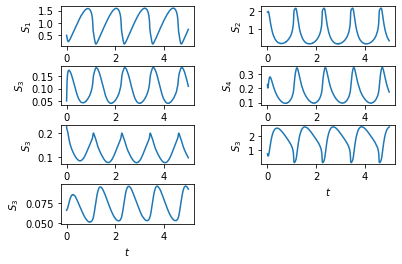

In [17]:
# Plot

plt.subplot(4,2,1)
plt.plot(time_points, sol[:,0])
plt.xlabel('$t$')
plt.ylabel('$S_1$')

plt.subplot(4,2,2)
plt.plot(time_points, sol[:, 1])
plt.xlabel('$t$')
plt.ylabel('$S_2$')

plt.subplot(4,2,3)
plt.plot(time_points, sol[:, 2])
plt.xlabel('$t$')
plt.ylabel('$S_3$')

plt.subplot(4,2,4)
plt.plot(time_points, sol[:, 3])
plt.xlabel('$t$')
plt.ylabel('$S_4$')

plt.subplot(4,2,5)
plt.plot(time_points, sol[:, 4])
plt.xlabel('$t$')
plt.ylabel('$S_3$')

plt.subplot(4,2,6)
plt.plot(time_points, sol[:, 5])
plt.xlabel('$t$')
plt.ylabel('$S_3$')

plt.subplot(4,2,7)
plt.plot(time_points, sol[:, 6])
plt.xlabel('$t$')
plt.ylabel('$S_3$')

plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

In [9]:
# create training data consisting of noisy measurements

sampling_rate = 5 # take measurement every 0.05 mins
noise = 0.01
gly_data = sol[0::sampling_rate, :]
gly_data += noise * gly_data.std(0) * np.random.randn(*gly_data.shape)

print("Training data size: ", gly_data.shape)

Training data size:  (100, 7)


In [11]:
# save the data to disk

with open('gly_data.npy', 'wb') as file:
    np.save(file, gly_data)

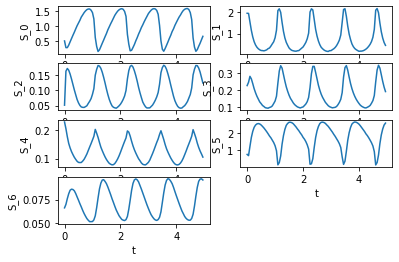

In [34]:
time_measurements = np.arange(0, 5, 0.01 * sampling_rate)

for species in range(7):
    plt.subplot(4,2,species + 1)
    plt.plot(time_measurements, gly_data[:,species])
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))

In [38]:
# sanity checks
print("Original vs Predicted")
print(gly_data[0,:])
print(x_init) # should be the same up to noise

print("Measurement interval")
print(time_measurements[1] - time_measurements[0]) # should give 0.05

Original vs Predicted
[0.50677647 1.93534573 0.05103011 0.2279497  0.22743185 0.7569
 0.06608424]
[0.50712444 1.92737262 0.05041518 0.22811383 0.22676696 0.74994409
 0.06602177]
Measurement interval
0.05


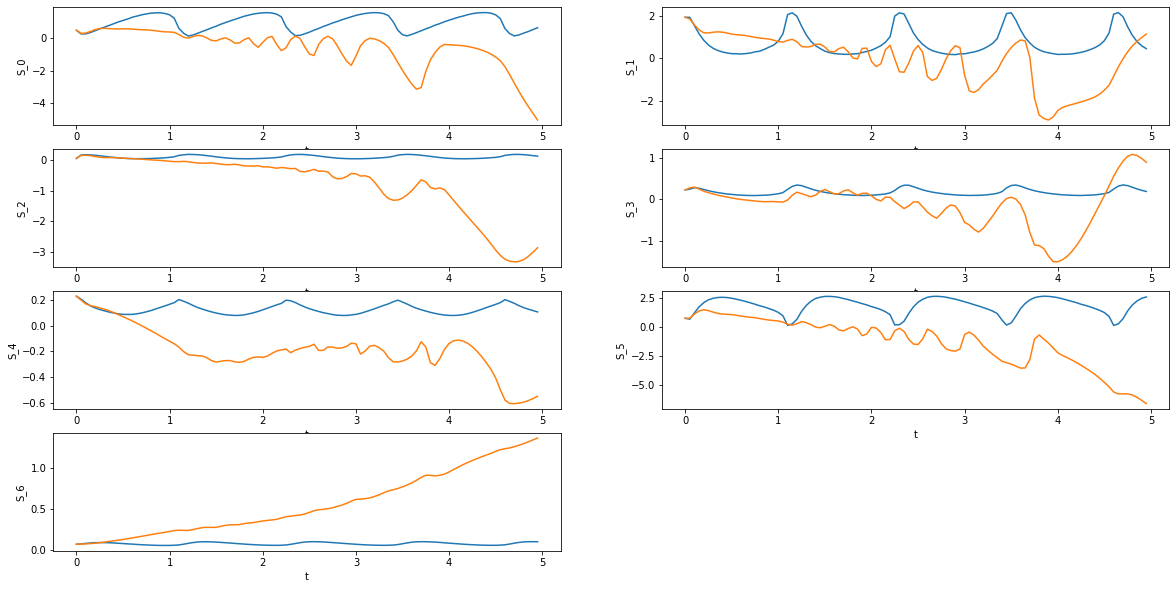

In [41]:
with open('gly_pred.npy', 'rb') as file:
    gly_pred = np.load(file)
    
plt.figure(figsize=(20, 10))
for species in range(7):
    plt.subplot(4,2,species + 1)
    plt.plot(time_measurements, gly_data[:,species])
    plt.plot(time_measurements, gly_pred[:,species])
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))